In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import tqdm.notebook

from cpe import CPE, Callback, SaveLossCallback, CallbackList
from cpe.celeba import Generator, Discriminator, Encoder


/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pythonian23/anaconda3/envs/CPE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
celeb_a = CelebA(root="/mnt/external/pytorch_datasets/", transform=transform, split="train", download=True)

dataloader = DataLoader(
    celeb_a,
    shuffle=True,
    batch_size=128,
)

Files already downloaded and verified


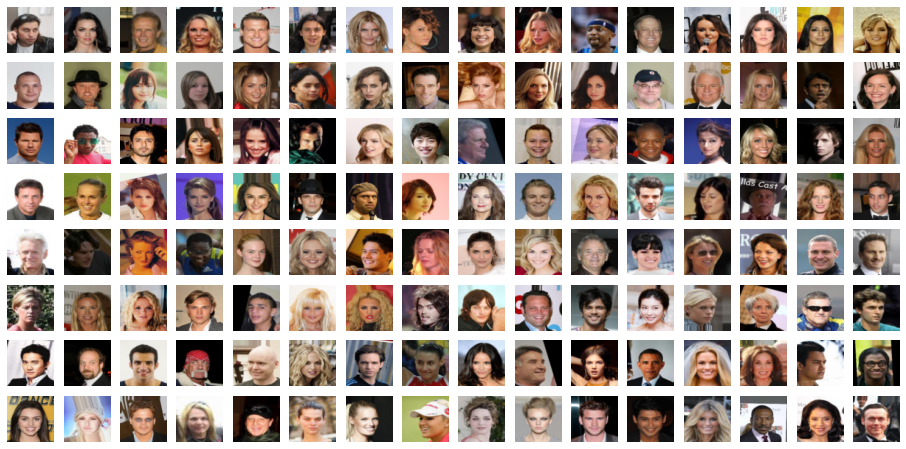

In [3]:
sample = next(iter(dataloader))[0]
plt.figure(figsize=(16, 8))
for i in range(128):
    plt.subplot(8, 16, i + 1)
    plt.imshow((sample[i].permute(1, 2, 0).numpy() + 1) / 2)
    plt.axis("off")
plt.show()

In [4]:
generator = Generator(100).to(device)
discriminator = Discriminator().to(device)
encoder = Encoder(100).to(device)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


generator.apply(weights_init)
discriminator.apply(weights_init)
encoder.apply(weights_init)

print(generator)
print(discriminator)
print(encoder)

cpe = CPE(encoder, generator, discriminator, 100, device=device)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2

In [5]:
g_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
e_optim = torch.optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [6]:
fixed_z = cpe.generate_z(15)


class CelebACallback(Callback):
    def __init__(self, z: torch.Tensor, recorder: SaveLossCallback):
        self.z = z
        self.maxbatch = 0
        self.recorder = recorder

    def plot_generated(self, model):
        plt.figure(figsize=(15, 1))
        with torch.no_grad():
            generated = model.generator(self.z.to(device)).detach().cpu()
        for i in range(15):
            plt.subplot(1, 15, i + 1)
            plt.imshow((generated[i].permute(1, 2, 0).numpy() + 1) / 2, cmap="gray")
            plt.axis("off")
        plt.show()

    def on_batch_end(
        self, epoch, batch, model, losses: tuple, epochs_iterator, batches_iterator: tqdm.notebook.tqdm_notebook
    ):
        batches_iterator.set_description("Real %4f | Fake %4f | Generator %4f" % losses)

    def on_epoch_end(self, epoch, model, epochs_iterator):
        self.plot_generated(model)



  0%|          | 0/10 [00:00<?, ?e/s]

  0%|          | 0/1272 [00:00<?, ?b/s]

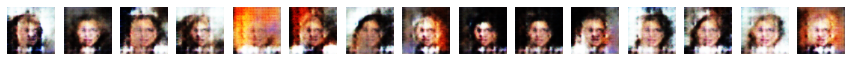

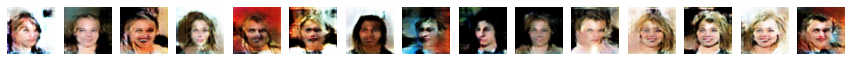

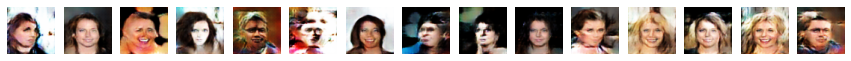

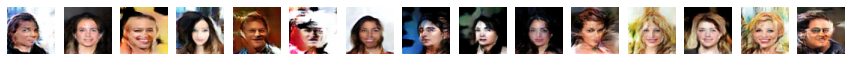

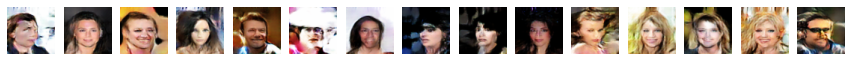

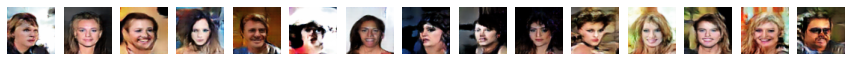

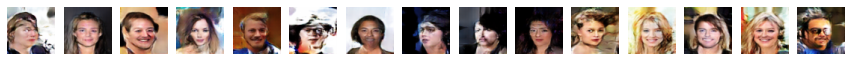

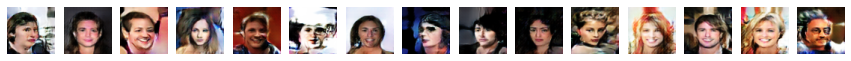

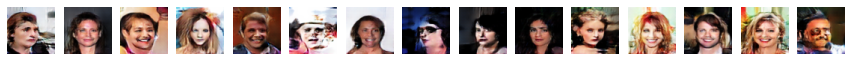

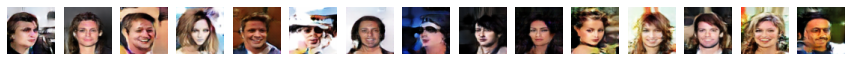

In [7]:
gan_recorder = SaveLossCallback(3, 10)
callback = CelebACallback(fixed_z, gan_recorder)
cpe.train_gan(10, g_optim, d_optim, dataloader, callback=CallbackList(callback, gan_recorder), use_tqdm=(2, 2))
torch.save(generator.state_dict(), "ca_generator.pth")
torch.save(discriminator.state_dict(), "ca_discriminator.pth")

In [8]:
encoder_recorder = SaveLossCallback(2, 10)

cpe.train_encoder(10, e_optim, dataloader, encoder_recorder, use_tqdm=(2, 2))
torch.save(encoder.state_dict(), "ca_encoder.pth")

  0%|          | 0/10 [00:00<?, ?e/s]

  0%|          | 0/1272 [00:00<?, ?b/s]

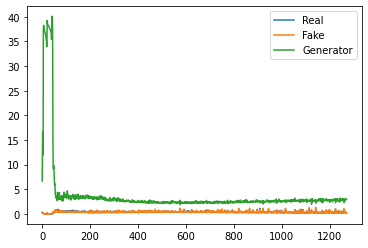

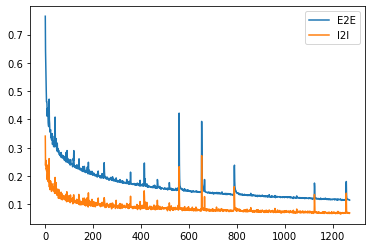

In [9]:
for loss in gan_recorder.losses:
    plt.plot(loss)
plt.legend(["Real", "Fake", "Generator"])
plt.figure()
for loss in encoder_recorder.losses:
    plt.plot(loss)
plt.legend(["E2E", "I2I"])
plt.show()

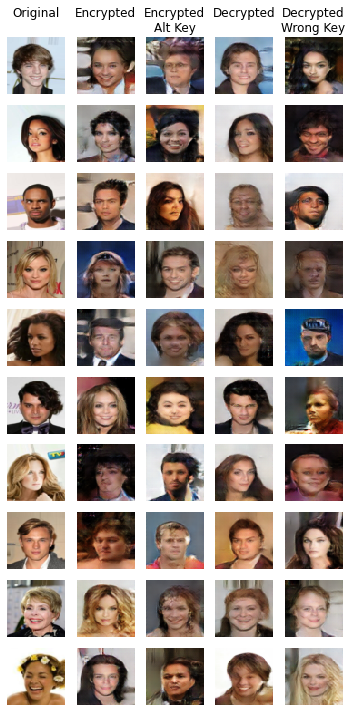

In [10]:
encoder.load_state_dict(torch.load("ca_encoder.pth"))
generator.load_state_dict(torch.load("ca_generator.pth"))

RESULTS = 10

generator.eval()
encoder.eval()
sign_swap = lambda x, k: x * torch.sign(k)
key = cpe.generate_z(RESULTS)
alt_key = cpe.generate_z(RESULTS)
pt = next(iter(dataloader))[0][:RESULTS].to(device)
pte = encoder(pt)
cte = sign_swap(pte, key)
ct = generator(cte)
alt_cte = sign_swap(pte, alt_key)
alt_ct = generator(alt_cte)
pter = sign_swap(encoder(ct), key)
ptr = generator(pter)
ptwr = sign_swap(encoder(ct), alt_key)
ptw = generator(ptwr)

imagify = lambda img: img.detach().cpu().numpy().squeeze().swapaxes(1, 2).swapaxes(2, 3) / 2 + 0.5
pto_images = imagify(pt)
cto_images = imagify(ct)
alt_cto_images = imagify(alt_ct)
ptr_images = imagify(ptr)
ptw_images = imagify(ptw)


plt.figure(figsize=(5, RESULTS))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(RESULTS):
    plt.subplot(RESULTS, 5, 5 * i + 1)
    plt.imshow(pto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[0])
    plt.subplot(RESULTS, 5, 5 * i + 2)
    plt.imshow(cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[1])
    plt.subplot(RESULTS, 5, 5 * i + 3)
    plt.imshow(alt_cto_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[2])
    plt.subplot(RESULTS, 5, 5 * i + 4)
    plt.imshow(ptr_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[3])
    plt.subplot(RESULTS, 5, 5 * i + 5)
    plt.imshow(ptw_images[i], cmap="gray", interpolation="nearest")
    plt.axis("off")
    if i == 0:
        plt.title(cols[4])
plt.tight_layout()
plt.savefig("results.png", transparent=False)
plt.show()
